# Time Series Analysis

## Import Libraries

In [49]:
import numpy as np
import pandas as pd
from plotly import express as px
from fbprophet import Prophet
import statsmodels.tsa.api as smt
from tqdm import tqdm_notebook as tqdm
from itertools import product
from scipy.stats import boxcox,ttest_1samp


## Data Preparation

In [2]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/wiki_machine_learning.csv'
df = pd.read_csv(url, sep=' ')
df.tail()

,date,count,lang,page,rank,month,title
382,2016-01-16,1644,en,Machine_learning,8708,201601,Machine_learning
381,2016-01-17,1836,en,Machine_learning,8708,201601,Machine_learning
376,2016-01-18,2983,en,Machine_learning,8708,201601,Machine_learning
375,2016-01-19,3389,en,Machine_learning,8708,201601,Machine_learning
372,2016-01-20,3559,en,Machine_learning,8708,201601,Machine_learning


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 81 to 372
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    384 non-null    object
 1   count   384 non-null    int64 
 2   lang    384 non-null    object
 3   page    384 non-null    object
 4   rank    384 non-null    int64 
 5   month   384 non-null    int64 
 6   title   384 non-null    object
dtypes: int64(3), object(4)
memory usage: 24.0+ KB


In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
df.describe()

,count,rank,month
count,384.000000,384.0,384.000000
mean,2331.445312,8708.0,201511.437500
std,669.885936,0.0,21.288182
min,0.000000,8708.0,201501.000000
25%,1723.500000,8708.0,201504.000000
50%,2431.500000,8708.0,201507.000000
75%,2783.500000,8708.0,201510.000000
max,4932.000000,8708.0,201601.000000


In [6]:
# Remove column with count of 0
df = df[df['count'] > 0]
df.shape

(383, 7)

In [7]:
# Plot counts 
fig = px.line(x=df['date'],
              y=df['count'])
fig.show()

## Predicting with FB Prophet


In [8]:
df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559



we need to split our dataset into the historical part, which is the first and biggest slice of our data, and the prediction part, which will be located at the end of the timeline. We will remove the last 30 days from the dataset in order to use it later as a prediction target:

In [9]:
predictions = 30

train_df = df[:-predictions]

model = Prophet()
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
forecast_df = model.make_future_dataframe(periods=predictions)
forecast = model.predict(forecast_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2979.319903,1690.763437,2536.401864,2959.615022,2997.590022,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,0.0,0.0,0.0,2117.626592
379,2016-01-17,2984.727592,1845.158327,2656.399602,2963.706271,3004.185625,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,0.0,0.0,0.0,2264.022238
380,2016-01-18,2990.135281,2876.831852,3673.058245,2967.561664,3010.835914,281.357669,281.357669,281.357669,281.357669,281.357669,281.357669,0.0,0.0,0.0,3271.492950
381,2016-01-19,2995.542971,3128.412969,3955.685504,2971.338568,3017.614502,541.423837,541.423837,541.423837,541.423837,541.423837,541.423837,0.0,0.0,0.0,3536.966808
382,2016-01-20,3000.950660,2999.801940,3813.622616,2974.959463,3024.288106,425.547911,425.547911,425.547911,425.547911,425.547911,425.547911,0.0,0.0,0.0,3426.498570


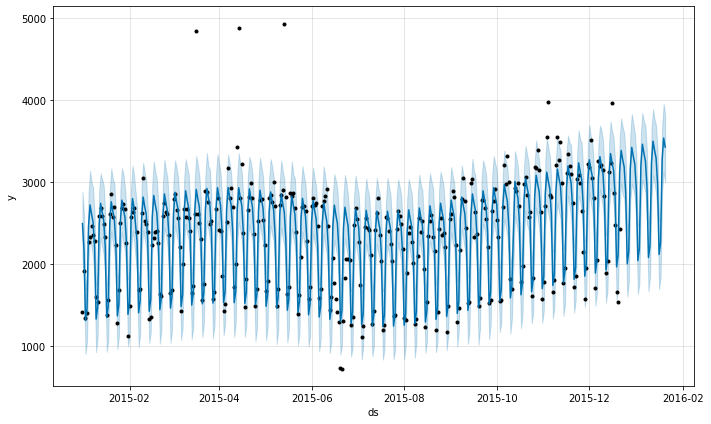

In [11]:
model.plot(forecast);

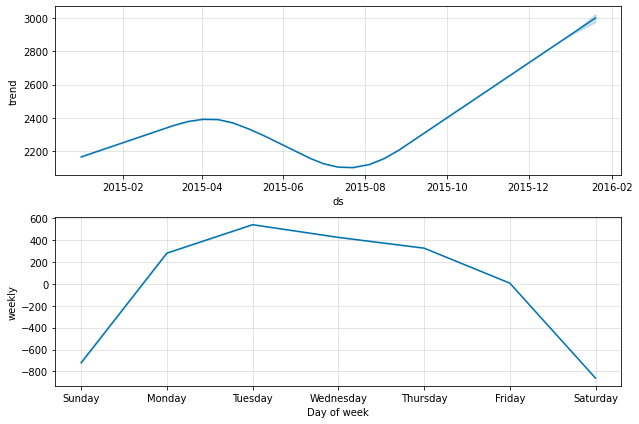

In [12]:
model.plot_components(forecast);

Evaluate the quality of our forecast with MAPE and MAE error measures:

In [13]:
cmp_df = forecast[['ds', 'yhat']].merge(df, left_on='ds', right_on='ds').set_index('ds')
cmp_df.tail()

,yhat,y
ds,,
2016-01-16,2117.626592,1644
2016-01-17,2264.022238,1836
2016-01-18,3271.492950,2983
2016-01-19,3536.966808,3389
2016-01-20,3426.498570,3559


We will define a helper function to calculate MAPE and MAE error of the forcast:

In [14]:
def calculate_forecast_errors(df, prediction_size):
  df = df.copy()

  df['Error'] = np.abs(df.yhat - df.y)
  df['Percentage'] = df.Error / df.y * 100

  predictions = df[:-prediction_size]

  mean_error = lambda column_name: np.mean(predictions[column_name])

  return {'MAE': round(mean_error('Error'), 2), 'MAPE': round(mean_error('Percentage'), 2)}

In [15]:
calculate_forecast_errors(cmp_df, predictions)

{'MAE': 187.48, 'MAPE': 8.57}

## Predicting with ARIMA
Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?

**Using weekly frequency:**

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15, 10)


Dickey-Fuller test shows a p-value of 0.107


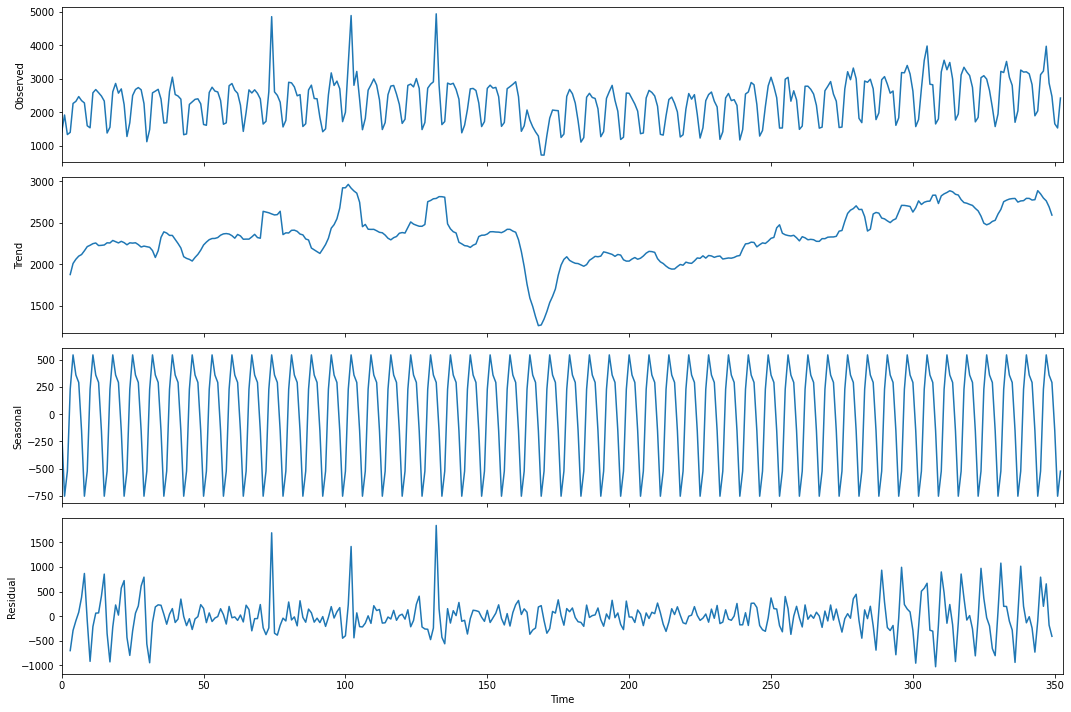

In [17]:
smt.seasonal_decompose(train_df.y.values, freq=7).plot();
print("Dickey-Fuller test shows a p-value of {:.3f}".format(smt.stattools.adfuller(train_df.y)[1]))

The series is not stationary. Let's examine the seasonality differentiated series:

In [18]:
train_df = train_df.set_index('ds')
train_df_diff = train_df - train_df.shift(7)
train_df_diff

,y
ds,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,NaN
...,...
2015-12-17,-274.0
2015-12-18,-351.0
2015-12-19,-238.0


Dickey-Fuller test shows a p-value of 0.000


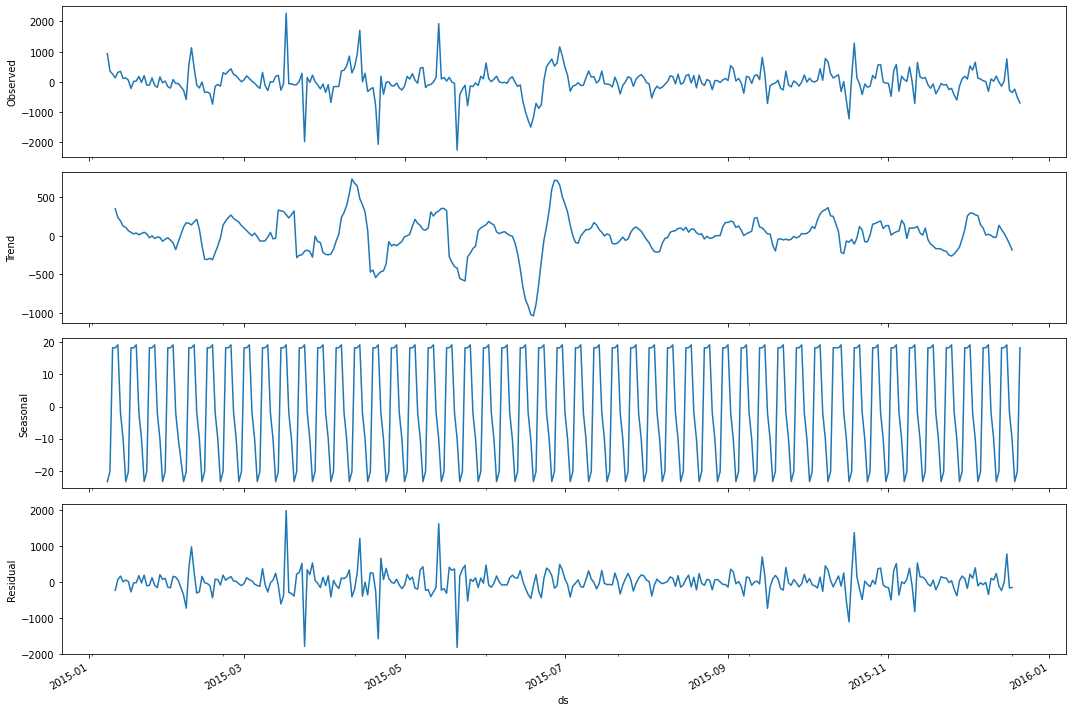

In [19]:
train_df_diff = train_df_diff[7:]
smt.seasonal_decompose(train_df_diff, freq=7).plot();
print("Dickey-Fuller test shows a p-value of {:.3f}".format(smt.stattools.adfuller(train_df_diff.y)[1]))

**Construct SARIMAX model**



Plot ACF and PACF:

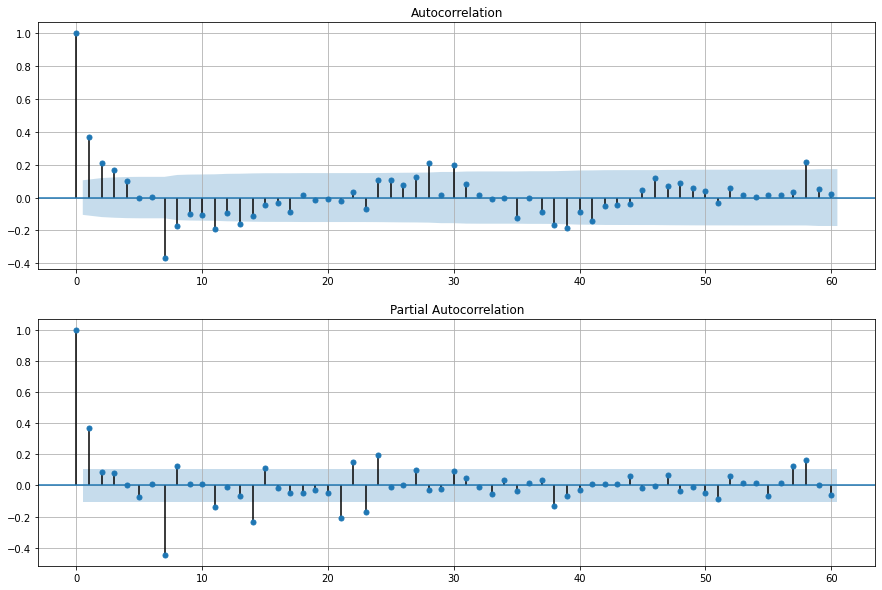

In [20]:
fig, ax = plt.subplots(2)
smt.graphics.plot_acf(train_df_diff, lags=60, ax=ax[0]);
ax[0].grid()
smt.graphics.plot_pacf(train_df_diff, lags=60, ax=ax[1]);
ax[1].grid()


Initial guess for SARIMA parameters:
* $p$ (significant lag on PACF, after which, most others are not significant): 1 
* $d$ (non-seasonal difference to make series stationary): not applied
* $q$ (significant lag on ACF, after which, most others are not significant): 3
* $P$ (number of significant lags on PACF): 3
* $D$ (number of seasonal difference applied): at least 1
* $Q$ (number of significant lags on ACF): 2


In [21]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(1, 3)
Qs = range(0, 3)

In [22]:
parameters = list(product(ps, ds, qs, Ps, Ds, Qs))
len(parameters)

384

In [23]:
def optimizeSARIMA(series, parameters_list, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        series - a series that we want to match
        parameters_list - list with (p, d, q, P, D, Q) tuples
        s - length of season
    """
    
    results = []

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=smt.statespace.SARIMAX(series, 
                                         order=(param[0], param[1], param[2]), 
                                         seasonal_order=(param[3], param[4], param[5], s)).fit()
        except:
            continue
        aic = model.aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
%%time
param_result = optimizeSARIMA(train_df, parameters, 7)


CPU times: user 27min 3s, sys: 20min 2s, total: 47min 5s
Wall time: 23min 51s


In [26]:
param_result.sort_values('aic', ascending=True).head()

,parameters,aic
0,"(0, 1, 2, 3, 2, 1)",4961.632628
1,"(1, 1, 1, 3, 2, 1)",4962.858934
2,"(0, 1, 3, 3, 2, 2)",4963.536589
3,"(1, 1, 3, 3, 2, 1)",4965.648758
4,"(1, 1, 3, 3, 2, 2)",4966.876842


We can fight non-stationarity using different approaches: various order differences, trend and seasonality removal, smoothing, and transformations like Box-Cox or logarithmic. Apply Box-Cox transformations and check AIC.

In [28]:
y_boxcox, lmbda = boxcox(train_df.y)
print("The lambda that maximizes log-likelihood function is {:.3f}".format(lmbda))

The lambda that maximizes log-likelihood function is 0.733


In [29]:
%%time
param_result = optimizeSARIMA(y_boxcox, parameters, 7)


CPU times: user 22min 51s, sys: 16min 54s, total: 39min 45s
Wall time: 20min 8s


In [30]:
param_result.sort_values('aic', ascending=True).head()

,parameters,aic
0,"(1, 0, 2, 3, 2, 1)",3528.650849
1,"(1, 0, 0, 3, 2, 2)",3529.512574
2,"(1, 0, 0, 3, 2, 1)",3530.524249
3,"(1, 0, 1, 3, 2, 2)",3531.359486
4,"(1, 1, 3, 3, 2, 1)",3531.814858


In [31]:
best_model = smt.statespace.SARIMAX(y_boxcox, order=(1, 0, 2), seasonal_order=(3, 2, 1, 7)).fit()

In [32]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.325
Date:                           Fri, 21 Aug 2020   AIC                           3528.651
Time:                                   20:10:12   BIC                           3559.259
Sample:                                        0   HQIC                          3540.848
                                           - 353                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8193      0.118      6.947      0.000       0.588       1.050
ma.L1         -0.3353      0.124     -2.698      0.007      -0.579      -0.092
ma.L2         -0.2019      0.091     -2.217      0.027      -0.380      -0.023
ar.S.L7       -0.6465      0.039    -16.429      0.000      -0.724      -0.569
ar.S.L14      -0.4303      0.059     -7.329      0.000      -0.545      -0.315
ar.S.L21      -0.2662      0.043     -6.185      0.000      -0.351      -0.182
ma.S.L7       -0.9996      3.026     -0.330      0.741      -6.930       4.931
sigma2      1633.1652   4922.592      0.332      0.740   -8014.937    1.13e+04
===================================================================================
Ljung-Box (Q):                       52.84   Jarque-Bera (JB):               528.39
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.95
Prob(H) (two-sided):                  0.12   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- d (non-seasonal difference) = 0
- D (seasonal difference) = 2

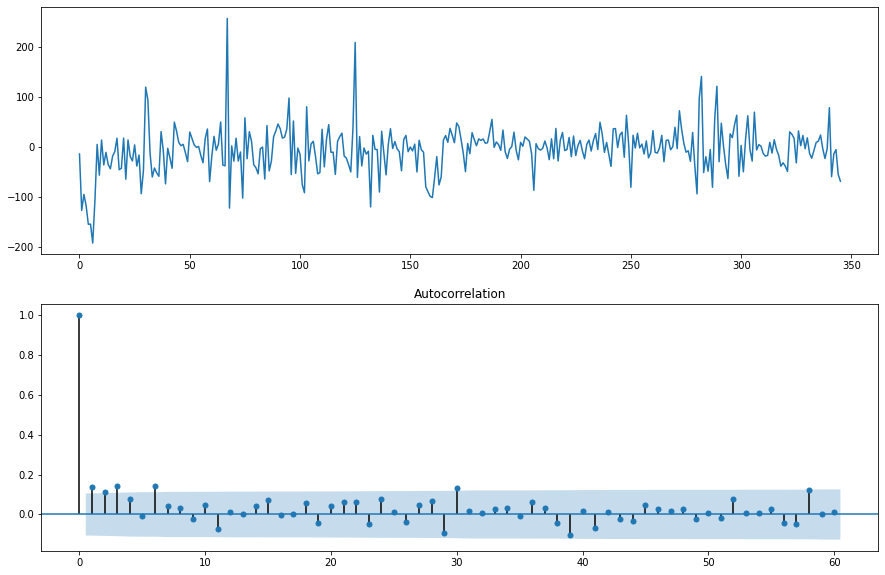

In [57]:
fig, ax = plt.subplots(2)
pd.Series(best_model.resid[7:]).plot(ax=ax[0]);
plt.ylabel = 'Residuals'

smt.graphics.plot_acf(best_model.resid[7:], lags=60, ax=ax[1]);

In [56]:
print('Deviation from mean of zero is {:.3f}'.format(ttest_1samp(best_model.resid[7:], 0)[1]))
print('Dickey Fuller test for stationality is {:.3f}'.format(smt.stattools.adfuller(best_model.resid[7:])[1]))

Deviation from mean of zero is 0.024
Dickey Fuller test for stationality is 0.000


Implement the inverse of this function in order to be able to restore the original data scale. 

In [58]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

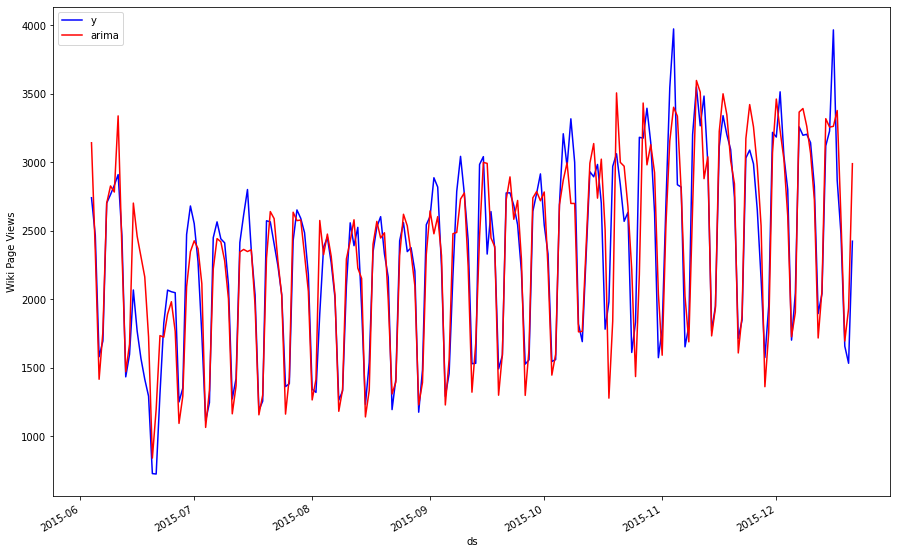

In [63]:
train_df['arima'] = inverse_boxcox(best_model.fittedvalues, lmbda)

ax = train_df.y.tail(200).plot(color='b')
train_df.arima.tail(200).plot(color='r', ax=ax)
ax.set_ylabel('Wiki Page Views')
ax.legend()